In [0]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import glob
import yaml
from pandas.api.types import is_numeric_dtype

In [0]:
%run ../0_Config.ipynb

In [0]:
def data_loading(path):
    if os.path.isdir(path):  
        all_files = os.listdir(path)
        all_files_ext = []
        for file_name in all_files:
            all_files_ext.append(os.path.splitext(file_name)[1])
        df = pd.DataFrame()
        
        if(".csv" in all_files_ext):
            for file_name in all_files:
                if('.csv' in file_name):
                    df = pd.concat([df,pd.read_csv(path + "/" + file_name)], ignore_index = True)
            return df
        elif(".parquet" in all_files_ext):
            for file_name in all_files:
                if('.parquet' in file_name):
                    df = pd.concat([df,pd.read_parquet(path + "/" + file_name, engine='pyarrow')], ignore_index = True)
            return df    
        else:
            assert False, "Only .csv or .parquet file types are supported"
        
    elif os.path.isfile(path):  
        file_type = os.path.splitext(path)[1]
        if(".csv" == file_type):
            df = pd.read_csv(path)
            return df
        elif(".parquet" == file_type):
            df = pd.read_parquet(path, engine='pyarrow')
            return df
        else:
            assert False, "Only .csv or .parquet file types are supported"
    else:  
        assert False, 'Path specified is not correct'

In [0]:
# required information
date_col = app_config['date_var']
modeling_gran = app_config['modeling_granularity']
dependent_var = app_config['dependent_variable']

In [0]:
df = data_loading(app_config["input_file_path"])
df[date_col] = pd.to_datetime(df[date_col],format = app_config["date_format_pandas"])
raw_df_count = df.shape[0]
print(raw_df_count)

1000

In [0]:
# Getting the count of nulls for all the columns
# nulls_df1 = pd.DataFrame(df.isnull().sum()).reset_index()
nulls_df1 = pd.DataFrame(df[df.isin([None,'None','NULL',np.nan,pd.NA,pd.NaT])].count()).reset_index()
nulls_df1.columns = ['Variable','#Nulls']
nulls_df1['%Nulls'] = (nulls_df1['#Nulls']/raw_df_count)*100

# Getting the count of zeros for all the numeric columns 
zeroVal_df1 = pd.DataFrame(df[df==0].count()).reset_index()
zeroVal_df1.columns = ['Variable','#Zeros']
zeroVal_df1['%Zeros'] = (zeroVal_df1['#Zeros']/raw_df_count)*100

# Getting the count of infinites for all the numeric columns 
infiniteVal_df1 = pd.DataFrame(df[df.isin([np.inf,-np.inf])].count()).reset_index()
infiniteVal_df1.columns = ['Variable','#Infinities']
infiniteVal_df1['%Infinities'] = (infiniteVal_df1['#Infinities']/raw_df_count)*100

# Concatenating all the results
final_df = nulls_df1.merge(zeroVal_df1,how='left',on='Variable').merge(infiniteVal_df1,how='left',on='Variable')
final_df[['#Nulls','#Zeros','#Infinities']] = final_df[['#Nulls','#Zeros','#Infinities']].round(0)
final_df[['%Nulls','%Zeros','%Infinities']] = final_df[['%Nulls','%Zeros','%Infinities']].round(1)
final_df

Out[13]:

,Variable,#Nulls,%Nulls,#Zeros,%Zeros,#Infinities,%Infinities
0,Div_No,0,0.0,0,0.0,0,0.0
1,Store_No,0,0.0,0,0.0,0,0.0
2,Base_UPC,0,0.0,0,0.0,0,0.0
3,Week_Start_Date,0,0.0,0,0.0,0,0.0
4,Sales_Qty_fill,0,0.0,0,0.0,0,0.0
5,Sales_Amt,0,0.0,0,0.0,0,0.0
6,AvgUnitPrice,0,0.0,0,0.0,0,0.0
7,median_baseprice,0,0.0,0,0.0,0,0.0
8,tpr_discount,0,0.0,605,60.5,0,0.0
9,New_cases,0,0.0,520,52.0,0,0.0


##### The user can treat the missing values in the "Missing value treatment" notebook.
The user can perform missing value treatment using the techniques mentioned in the config. The user has the flexibility to use a mix of the techniques by providing the appropriate column names in each section in the config file.

In [0]:
temp_idvs = []
all_algos = [algo for algo in app_config['Algorithms'].keys() if algo not in ['DeepAR','DeepState']]
for algo in all_algos:
    if("exogenous_variables" in app_config['Algorithms'][algo].keys()):
        temp_idvs = temp_idvs + (app_config['Algorithms'][algo]['exogenous_variables']['positive_corr']+\
                                 app_config['Algorithms'][algo]['exogenous_variables']['negative_corr']+\
                                 app_config['Algorithms'][algo]['exogenous_variables']['uncertain_corr'])
for algo in ['DeepAR','DeepState']:
    temp_idvs = temp_idvs + (app_config['Algorithms'][algo]['exogenous_variables']['feat_dynamic_real'])
    
idvs = list(set(temp_idvs))
final_df1 = final_df[final_df['Variable'].isin(idvs+[dependent_var])].reset_index(drop = True)
final_df1

Out[14]:

,Variable,#Nulls,%Nulls,#Zeros,%Zeros,#Infinities,%Infinities
0,Sales_Qty_fill,0,0.0,0,0.0,0,0.0
1,AvgUnitPrice,0,0.0,0,0.0,0,0.0
2,median_baseprice,0,0.0,0,0.0,0,0.0
3,tpr_discount,0,0.0,605,60.5,0,0.0
4,New_cases,0,0.0,520,52.0,0,0.0
5,stateLevel_grocery_and_pharmacy_percent_change...,0,0.0,796,79.6,0,0.0


##### There should not be any duplicates at the Modelling_Granularity x Date. 
Please clean the data before proceeding to the data processing or modelling notebooks if there are any duplicates

In [0]:
duplicates_check = df[modeling_gran + [date_col]].drop_duplicates()
duplicates_check_count = duplicates_check.shape[0]

print("There are " +str(raw_df_count-duplicates_check_count)+" duplicates at the modeling_granularity x date")

There are 0 duplicates at the modeling_granularity x date

##### Basic summary of the data

In [0]:
summary_df = df.groupby(modeling_gran).agg(min_time_period = (date_col,'min'),
                                            max_time_period = (date_col,'max'),
                                            datapoints = (date_col,'count')).reset_index()
summary_df1 = duplicates_check.groupby(modeling_gran).agg(datapoints_WO_duplicates = (date_col,'count')).reset_index()
fin_summary_df = summary_df.merge(summary_df1, on = modeling_gran ,how = "left")
fin_summary_df.rename(columns = {'datapoints':'#datapoints','datapoints_WO_duplicates':'#datapoints_WO_duplicates'},inplace=True)
display(fin_summary_df)

Div_No,Store_No,Base_UPC,min_time_period,max_time_period,#datapoints,#datapoints_WO_duplicates
Div_No1,Store_No1,Base_UPC1,2018-08-08T00:00:00.000+0000,2021-07-28T00:00:00.000+0000,156,156
Div_No1,Store_No2,Base_UPC2,2018-08-08T00:00:00.000+0000,2021-07-28T00:00:00.000+0000,156,156
Div_No1,Store_No3,Base_UPC3,2018-08-08T00:00:00.000+0000,2021-07-28T00:00:00.000+0000,156,156
Div_No1,Store_No4,Base_UPC4,2018-08-08T00:00:00.000+0000,2021-07-28T00:00:00.000+0000,156,156
Div_No1,Store_No5,Base_UPC5,2018-08-08T00:00:00.000+0000,2021-07-28T00:00:00.000+0000,156,156
Div_No1,Store_No6,Base_UPC6,2018-08-08T00:00:00.000+0000,2021-07-28T00:00:00.000+0000,156,156
Div_No1,Store_No6,Base_UPC7,2018-08-08T00:00:00.000+0000,2019-10-23T00:00:00.000+0000,64,64


##### There should not be any dates missing in the series at the Modelling_Granularity level. 
Please clean the data before proceeding to the data processing or modelling notebooks if there are any such cases

In [0]:
# Getting the unique dates and the frequency
temp_dates1 = duplicates_check[[date_col]].drop_duplicates()
print("Unique Dates",temp_dates1.shape[0])
history_dates = pd.to_datetime(pd.Series(temp_dates1[date_col].unique(), name='ds')).sort_values()
frequency = pd.infer_freq(history_dates.tail(3))
print("frequency",frequency)

# Checking for the dates missing if any
min_max_dates = fin_summary_df[['min_time_period','max_time_period','#datapoints_WO_duplicates']].drop_duplicates().reset_index(drop = True)
min_max_dates['data_missing'] = 1
min_max_dates['#total_data_points'] = min_max_dates['#datapoints_WO_duplicates'].copy()

df_len = len(min_max_dates)
for row in range(df_len):
    start_date = min_max_dates.loc[row,'min_time_period']
    end_date = min_max_dates.loc[row,'max_time_period']
    data_count = len(pd.date_range(start_date, end_date, freq=frequency))
    if(data_count== min_max_dates.loc[row,'#datapoints_WO_duplicates']):
        min_max_dates.loc[row,'data_missing'] = 0
    min_max_dates.loc[row,'#total_data_points'] = data_count

min_max_dates1 = min_max_dates[min_max_dates['data_missing']==1]
del(min_max_dates1['data_missing'])

missing_dates_data = pd.merge(fin_summary_df[modeling_gran+['min_time_period','max_time_period','#datapoints_WO_duplicates']],\
                              min_max_dates1,\
                              on = ['min_time_period','max_time_period','#datapoints_WO_duplicates'],how='right')
missing_dates_data = missing_dates_data.rename(columns = {'#datapoints_WO_duplicates':'#available_data_points'})
missing_dates_data['#missing_data_points'] = missing_dates_data['#total_data_points'] - missing_dates_data['#available_data_points']
missing_dates_data

Unique Dates 156
frequency W-WED
Out[17]:

,Div_No,Store_No,Base_UPC,min_time_period,max_time_period,#available_data_points,#total_data_points,#missing_data_points


##### Checking whether all the products have the same latest date or not
Please check the data once whether these products are discontinued or dying down if there any such cases

In [0]:
max_date = fin_summary_df['max_time_period'].max()
missing_latest_date_data = fin_summary_df[fin_summary_df['max_time_period']!=max_date]
print("Latest date is" , max_date)
if(missing_latest_date_data.shape[0]):
    missing_latest_date_data.insert(len(modeling_gran)+2, 'latest_date',max_date)
missing_latest_date_data

Latest date is 2021-07-28 00:00:00
Out[18]:

,Div_No,Store_No,Base_UPC,min_time_period,max_time_period,latest_date,#datapoints,#datapoints_WO_duplicates
6,Div_No1,Store_No6,Base_UPC7,2018-08-08,2019-10-23,2021-07-28,64,64


#### Plotting the First Period Distribution of all the time series.

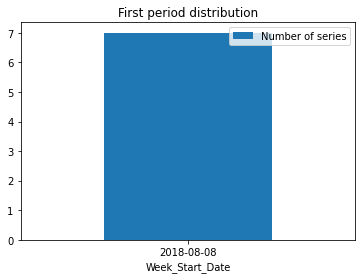

In [0]:
hist_start_dates_df = fin_summary_df.groupby('min_time_period').agg(count = (modeling_gran[0],'count')).reset_index()
hist_start_dates_df = hist_start_dates_df.sort_values(by = 'min_time_period', ascending = True)
hist_start_dates_df.columns = [date_col,'Number of series']
hist_start_dates_df[date_col] = hist_start_dates_df[date_col].astype(str)
hist_start_dates_df.plot.bar(x=date_col, y='Number of series', rot=0, title = 'First period distribution');

In [0]:
def correlation_distribution_with_target(
    df: pd.DataFrame,
    groupby_cols: list,
    target_col: str,
    input_cols: list,
    bucket_width: float = 0.1,
    called_from: str = "external",
):
   
    if called_from not in {"external", "internal"}:
        raise ValueError(
            f"called_from must be either 'external' or 'internal'; received {called_from} instead"
        )

    if called_from == "external":
        if not is_numeric_dtype(df[target_col].dtype):
            raise VariableTypeError(
                f"target_col - {target_col} - is not numerical; correlation requires numerical variables"
            )
        for inp_col in input_cols:
            if not is_numeric_dtype(df[inp_col].dtype):
                raise VariableTypeError(
                    f"{inp_col} in input_cols is not numerical; correlation requires numerical variables"
                )

    def target_corr(df, target_col, input_cols):
        # return df[input_cols].corrwith(df[target_col])
        target_col_variance = df[target_col].var(skipna=True)
        if pd.isna(target_col_variance) | (target_col_variance == 0):
            return pd.Series([np.nan] * len(input_cols), index=input_cols)
        s = df[input_cols].corrwith(df[target_col])
        cols_with_nan_result = list(s[s.isna()].index)
        for col in cols_with_nan_result:
            if ((s_nonna := df[[col, target_col]].notna().all(axis=1)).sum()) > 1:
                if (np.around(df[target_col][s_nonna].var(), 5) == 0) ^ (
                    np.around(df[col][s_nonna].var(), 5) == 0
                ):
                    s.loc[col] = 0.0
                elif (np.around(df[target_col][s_nonna].var(), 5) == 0) & (
                    np.around(df[col][s_nonna].var(), 5) == 0
                ):
                    pass
                else:
                    raise ValueError(
                        f"Unhandled reason for NaN as correlation in {col} at a particular granularity level"
                    )
        return s

    correlation_table = df.groupby(groupby_cols, sort=False)[
        [target_col, *input_cols]
    ].apply(func=target_corr, target_col=target_col, input_cols=input_cols)
    correlation_bucket = pd.DataFrame()
    bins = np.arange(start=-1.0, stop=1.0 + bucket_width, step=bucket_width).round(
        decimals=1
    )
    for col in input_cols:
        if (
            correlation_table[col].notna().any()
        ):  # if there is a single non-na value at any granularity level only then do correlation distribution generation; else leave out that column entirely.
            correlation_bucket[col] = (
                pd.cut(correlation_table[col], bins=bins, right=False)
                .value_counts(sort=False, normalize=True)
                .mul(100)
                .round(1)
            )
    if len(correlation_bucket.columns) == 0:
        raise InsufficientDataError(
            "Not enough non-null values to calculate correlation distribution for any column in input_cols"
        )

    return correlation_bucket.T.rename_axis(index="Variable").sort_index()

In [0]:
if(len(idvs)>0):
    # adjust the bucket_width according to the requirement
    bucket_width = 0.2
    cor_dist = correlation_distribution_with_target(df,modeling_gran,dependent_var,\
                                         idvs,bucket_width,'external')
    cor_dist.columns = cor_dist.columns.add_categories(['Variable'])
    cor_dist = cor_dist.reset_index()
    cor_dist

Out[21]:

,Variable,"[-1.0, -0.8)","[-0.8, -0.6)","[-0.6, -0.4)","[-0.4, -0.2)","[-0.2, -0.0)","[-0.0, 0.2)","[0.2, 0.4)","[0.4, 0.6)","[0.6, 0.8)","[0.8, 1.0)"
0,AvgUnitPrice,0.0,28.6,42.9,28.6,0.0,0.0,0.0,0.0,0.0,0.0
1,New_cases,0.0,0.0,0.0,14.3,42.9,42.9,0.0,0.0,0.0,0.0
2,median_baseprice,0.0,0.0,0.0,14.3,42.9,42.9,0.0,0.0,0.0,0.0
3,stateLevel_grocery_and_pharmacy_percent_change...,0.0,0.0,0.0,0.0,28.6,42.9,28.6,0.0,0.0,0.0
4,tpr_discount,0.0,0.0,0.0,0.0,0.0,0.0,28.6,28.6,42.9,0.0


In [0]:
# update the below information according to the data
train_percentage = 0.7
no_of_backtesting_test_periods = 5
no_of_test_periods = 8
stride = 5
Total_data_points = 156 
backtesting_algo = 'expanding_window' #sliding_window/expanding_window


train_interval = int((Total_data_points-no_of_test_periods) * train_percentage)
train_period_ends = Total_data_points-no_of_test_periods
count = 0
train_index_start = 0
print('train_index_start','train_index_end','test_index_end')
for train_i in range(train_interval,train_period_ends,stride):
    if(train_i+no_of_backtesting_test_periods <=train_period_ends):
        test_i = train_i+no_of_backtesting_test_periods
        count = count+1
        if(backtesting_algo == 'sliding_window'):
            train_index_start = train_index_start+stride
        print(train_index_start,train_i,train_i+no_of_backtesting_test_periods)
        
print("Total iterations",count)

train_index_start train_index_end test_index_end
0 103 108
0 108 113
0 113 118
0 118 123
0 123 128
0 128 133
0 133 138
0 138 143
0 143 148
Total iterations 9